# **DIPLOMATURA UNIVERSITARIA EN CIENCIA DE DATOS**

# Módulo 5: Aprendizaje No Supervisado

## Clustering: DBscan, HDBscan.

## **Docentes:** Lic. Luis Duarte - Dra. Griselda Bobeda  - Dra. Magdalena Lucini

### Noviembre 2024, FaCENA - UNNE

### Contacto:  
* luis.duarte@comunidad.unne.edu.ar;
* griseldabobeda@gmail.com;
* mmlucini@comunidad.unne.edu.ar



**Objetivos:**

*   Aplicar técnicas de clustering a bases de datos reales.
*   Comparar agrupaciones con diferentes ténicas.

**Antes de empezar:**

Necesitamos importar las siguientes librerías:

In [ ]:
import numpy as np
import pandas as pd
import io
#import seaborn as sns
from google.colab import files
from sklearn.preprocessing import StandardScaler

In [ ]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt

## Clustering: DBSCAN

**Density Based Spatial Clusterig of Applications with Noise
(DBSCAN)**\
▶ **Clusters:** regiones densas en el espacio de datos, separadas
por regiones de baja densidad de puntos.\
▶ **Idea básica:** Para que un punto pertenzca a un cluster, un
entorno de un radio dado, centrado en ese punto, tiene que
contener una cantidad mínima de puntos.\
▶ Puede encontrar clusters de diferentes formas y tamaños,
detecta ruido y puntos outliers.

**Parámetros**:\
▶ $\mathbf{\epsilon}$ (eps) = define el entorno (vecindad) de un punto: Si
$d\left(x_i, x_j\right)< \epsilon ⇒ x_i \text{ y } x_j$ son “vecinos”.\
▶ **min Pts**: número mínimo de vecinos (puntos) dentro de un
radio $\epsilon$ (define así zonas “densas”).

**Criterios de Elección de Parámetros:**
* **min Pts**\
▶ $min Pts \geq p + 1$, con $p=$ cantidad de variables.\
▶ Si el data set es pequeño o muy ruidoso, debe ser $min Pts\geq 2p$.

* $\mathbf{\epsilon}$\
▶ $\epsilon$ pequeño → muchos datos sin agrupar; $\epsilon$ muy grande → la
mayoría de los datos en un mismo grupo.\
▶ puede elegirse usando un gráfico de distancias (gráfico de
codo, knee graph), representando la distancia al $k= min Pts-1$ vecino más cercano, ordenadas de mayor a menor. Se elige $\epsilon$ donde se observa un codo.\
▶ para cada punto se detecta su vecino más cercano, se fija $\epsilon$
de manera tal que una proporción suficientemente gande de
observaciones (> 90%) tenga una distancia a su vecino más
cercano inferior a $\epsilon$.


## **Caso 1: Base de datos de Country.**

### **1.1 Repliquemos lo hecho en la clase anterior:**

In [ ]:
uploaded = files.upload()

Saving Country.csv to Country.csv


In [ ]:
paises = pd.read_csv(io.BytesIO(uploaded['Country.csv']))

In [ ]:
paises.shape

(167, 10)

In [ ]:
paises1=paises.drop(['country'],axis=1)

In [ ]:
paises1['exports'] = paises1['exports']*paises1['gdpp']/100
paises1['imports'] = paises1['imports']*paises1['gdpp']/100
paises1['health'] = paises1['health']*paises1['gdpp']/100

In [ ]:
scaler = StandardScaler()
paises_esc = scaler.fit_transform(paises1)

In [ ]:
from sklearn.decomposition import PCA
pcaf = PCA(n_components=5)
paises_pca = pd.DataFrame(pcaf.fit_transform(paises_esc))
paises_pca.columns = ['PC1','PC2','PC3','PC4', 'PC5']

### **1.2 Elección de hiperparámetros.**

Recordando que estamos trabajando con $p=5$ variables, podemos iniciar el estudio utilizando $minPts=5+1=6$.

Para elegir $\epsilon$, realizaremos el gráfico de los $k$-vecinos cercanos, utilizando $k=5$.

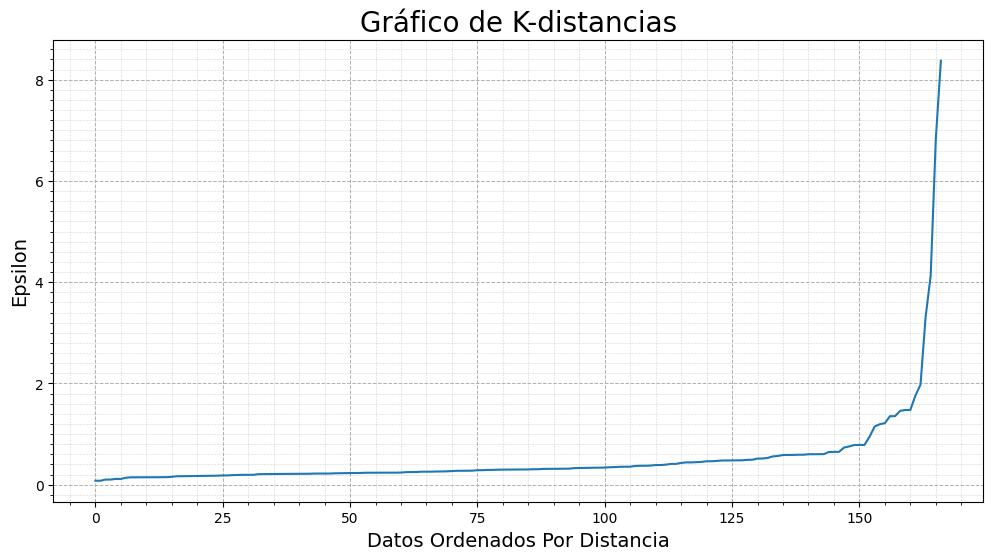

In [ ]:
from sklearn.neighbors import NearestNeighbors
#https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.NearestNeighbors.html

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(paises_pca)
distances, indices = nbrs.kneighbors(paises_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(12,6))
plt.plot(distances)
plt.title('Gráfico de K-distancias',fontsize=20)
plt.xlabel('Datos Ordenados Por Distancia',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.minorticks_on()
plt.grid(True, which='major', linestyle='--', linewidth=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.4)

# Ajustar los ticks menores para una cuadrícula más densa
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.2))  # Ajusta el valor para hacerla más densa en el eje y
plt.show()

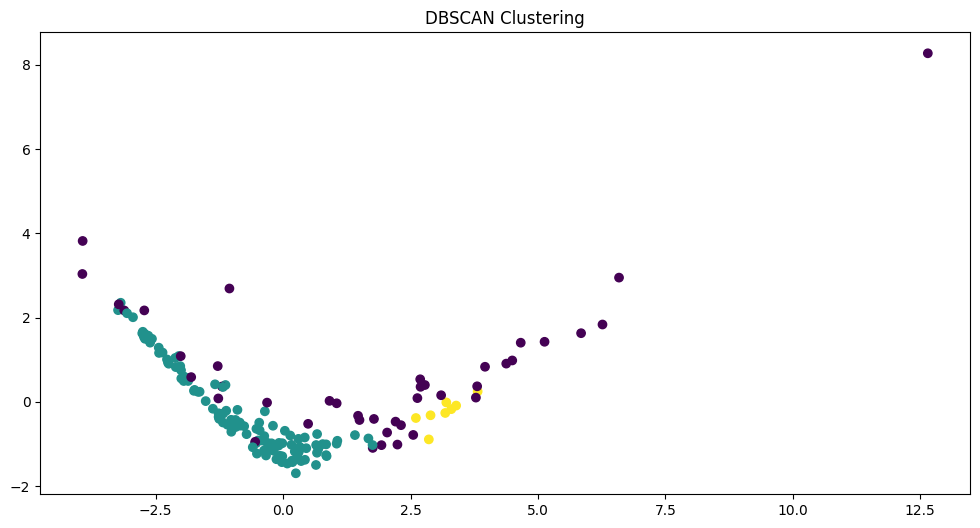

In [ ]:
from sklearn.cluster import DBSCAN
#https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.HDBSCAN.html

dbscan = DBSCAN(eps=0.7, min_samples=6)
clusters = dbscan.fit_predict(paises_pca)

# Visualizar el resultado
plt.figure(figsize=(12,6))
plt.scatter(paises_pca['PC1'], paises_pca['PC2'], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

In [ ]:
pd.Series(clusters).value_counts()

,count
0,117
-1,42
1,8


In [ ]:
proporcion_ruido = np.sum(clusters == -1) / len(clusters)
print(f"Proporción de puntos de ruido: {proporcion_ruido:.2%}")


Proporción de puntos de ruido: 25.15%


Creemos una grilla de valores posibles para ambos hiperparámetros. Probemos con valores $ϵ\in \left\lbrace 0.6,0.7, 0.8, 1.5\right\rbrace$ y $minPts \in \left\lbrace 6, 10, 12\right\rbrace$.

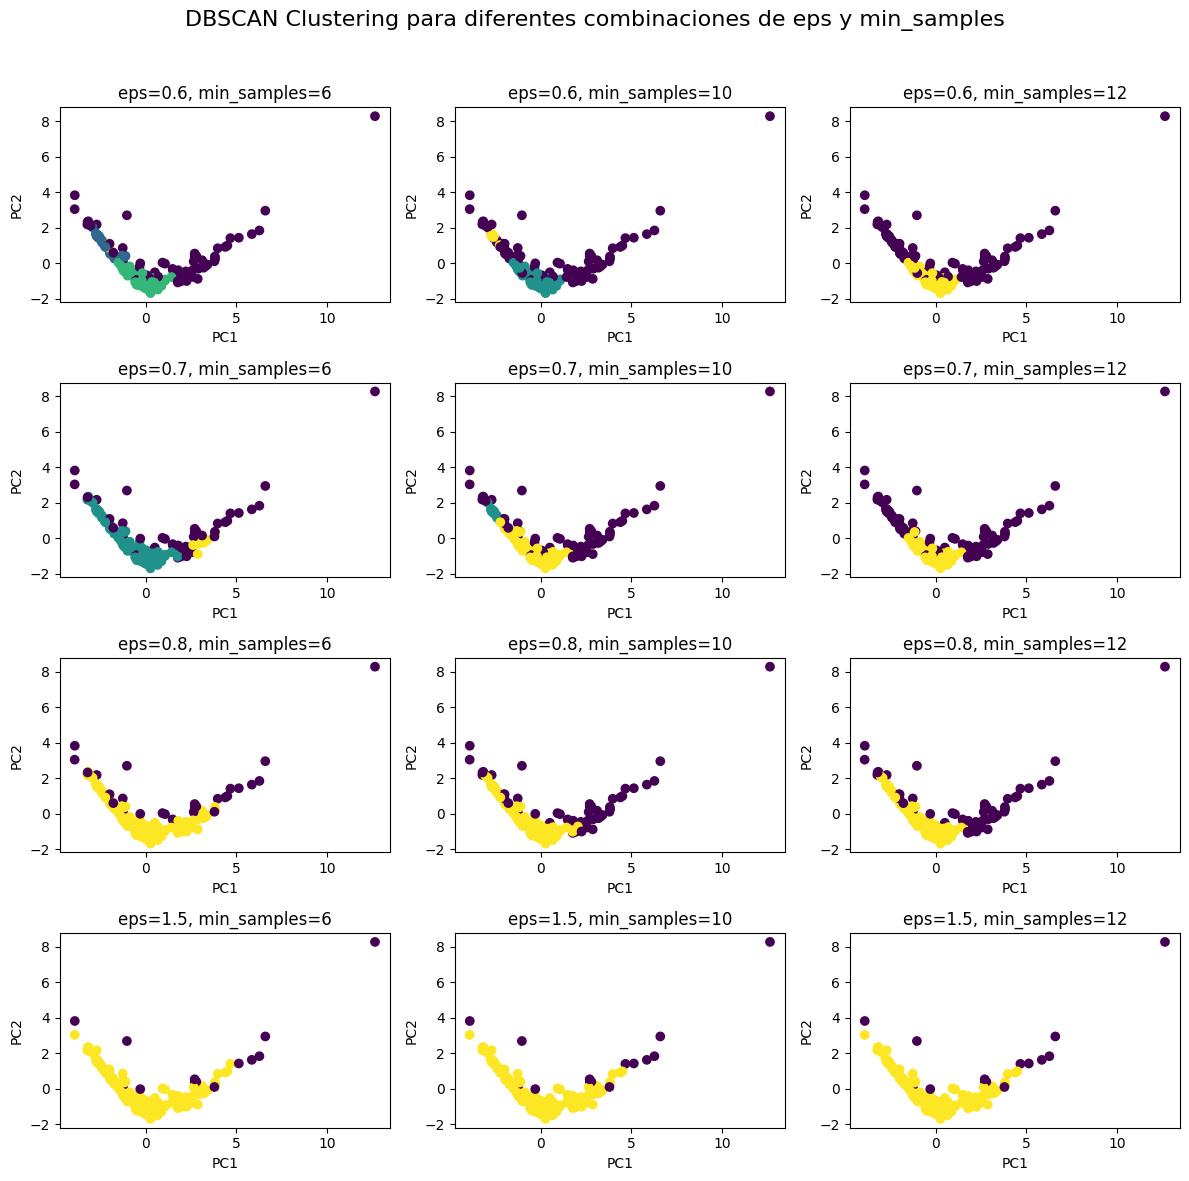

Coeficientes de Silueta para cada combinación de eps y min_samples:
           6         10   12
0.6  0.203748  0.111088  NaN
0.7  0.287725   0.22433  NaN
0.8       NaN       NaN  NaN
1.5       NaN       NaN  NaN


In [ ]:
from sklearn.metrics import silhouette_score

eps_values = [0.6, 0.7, 0.8, 1.5]
min_samples_values = [6, 10, 12]
silhouette_table = pd.DataFrame(index=eps_values, columns=min_samples_values)
# Crear la figura y los ejes para la grilla de gráficos
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(12, 12))
fig.suptitle('DBSCAN Clustering para diferentes combinaciones de eps y min_samples', fontsize=16)

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(paises_pca)

        # Calcular el coeficiente de silueta si hay más de 1 cluster
        if len(set(clusters)) >2:
            silhouette_avg = silhouette_score(paises_pca, clusters)
        else:
            silhouette_avg = np.nan

        # Guardar el coeficiente en la tabla
        silhouette_table.loc[eps, min_samples] = silhouette_avg
        ax = axes[i, j]
        scatter = ax.scatter(paises_pca['PC1'], paises_pca['PC2'], c=clusters, cmap='viridis')
        ax.set_title(f'eps={eps}, min_samples={min_samples}')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("Coeficientes de Silueta para cada combinación de eps y min_samples:")
print(silhouette_table)

Elegimos finalmente $\epsilon=0.7$ y $minPts=6$.

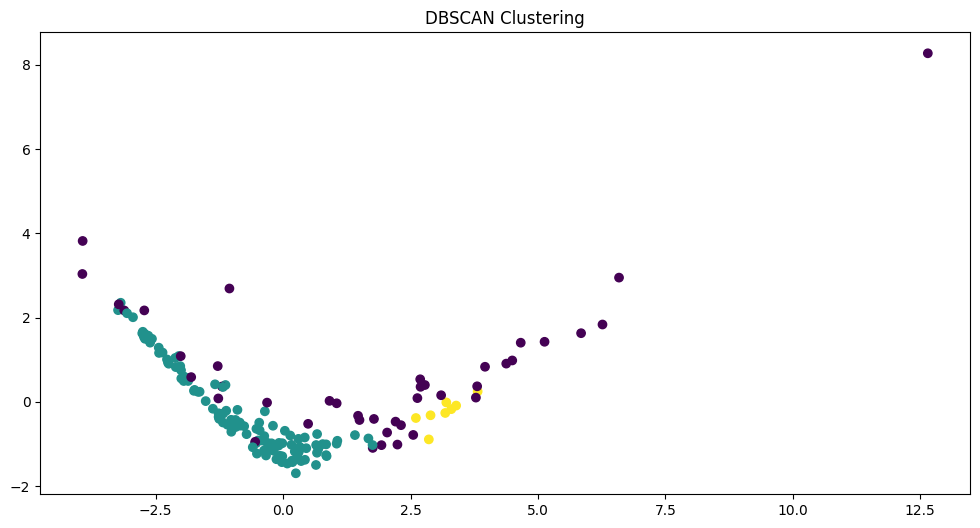

In [ ]:
dbscan = DBSCAN(eps=0.7, min_samples=6)
clustersf = dbscan.fit_predict(paises_pca)

# Visualizar el resultado
plt.figure(figsize=(12,6))
plt.scatter(paises_pca['PC1'], paises_pca['PC2'], c=clustersf, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

### **1.3 Analicemos cada uno de los clusters.**

In [ ]:
paises_nuevo=pd.merge(paises,pd.Series(clustersf, index=paises.index, name='Cluster'), left_index=True,right_index=True)
paises_nuevo.head(2)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0


* Media de cada variable agrupada por cluster.

In [ ]:
cluster_child_mort=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).child_mort.mean())
cluster_exports=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).exports.mean())
cluster_health=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).health.mean())
cluster_imports=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).imports.mean())
cluster_income=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).income.mean())
cluster_inflation=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).inflation.mean())
cluster_life_expec=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).life_expec.mean())
cluster_total_fer=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).total_fer.mean())
cluster_gdpp=pd.DataFrame(paises_nuevo.groupby(["Cluster"]).gdpp.mean())

In [ ]:
# Armamos un data frame con las medias de cada variable por cluster.
media_db=pd.concat([cluster_child_mort,cluster_exports,cluster_health,cluster_imports,cluster_income,cluster_inflation,cluster_life_expec, cluster_total_fer,cluster_gdpp],axis=1).reset_index()
media_db

,Cluster,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,-1,31.111905,56.150000,7.369524,49.152381,35818.547619,12.375595,74.166667,2.728333,29839.880952
1,0,43.161538,36.373496,6.376838,47.175777,8926.358974,6.607342,68.541880,3.112137,4731.102564
2,1,4.312500,31.400000,10.326250,30.837500,39300.000000,0.841500,81.050000,1.700000,44775.000000


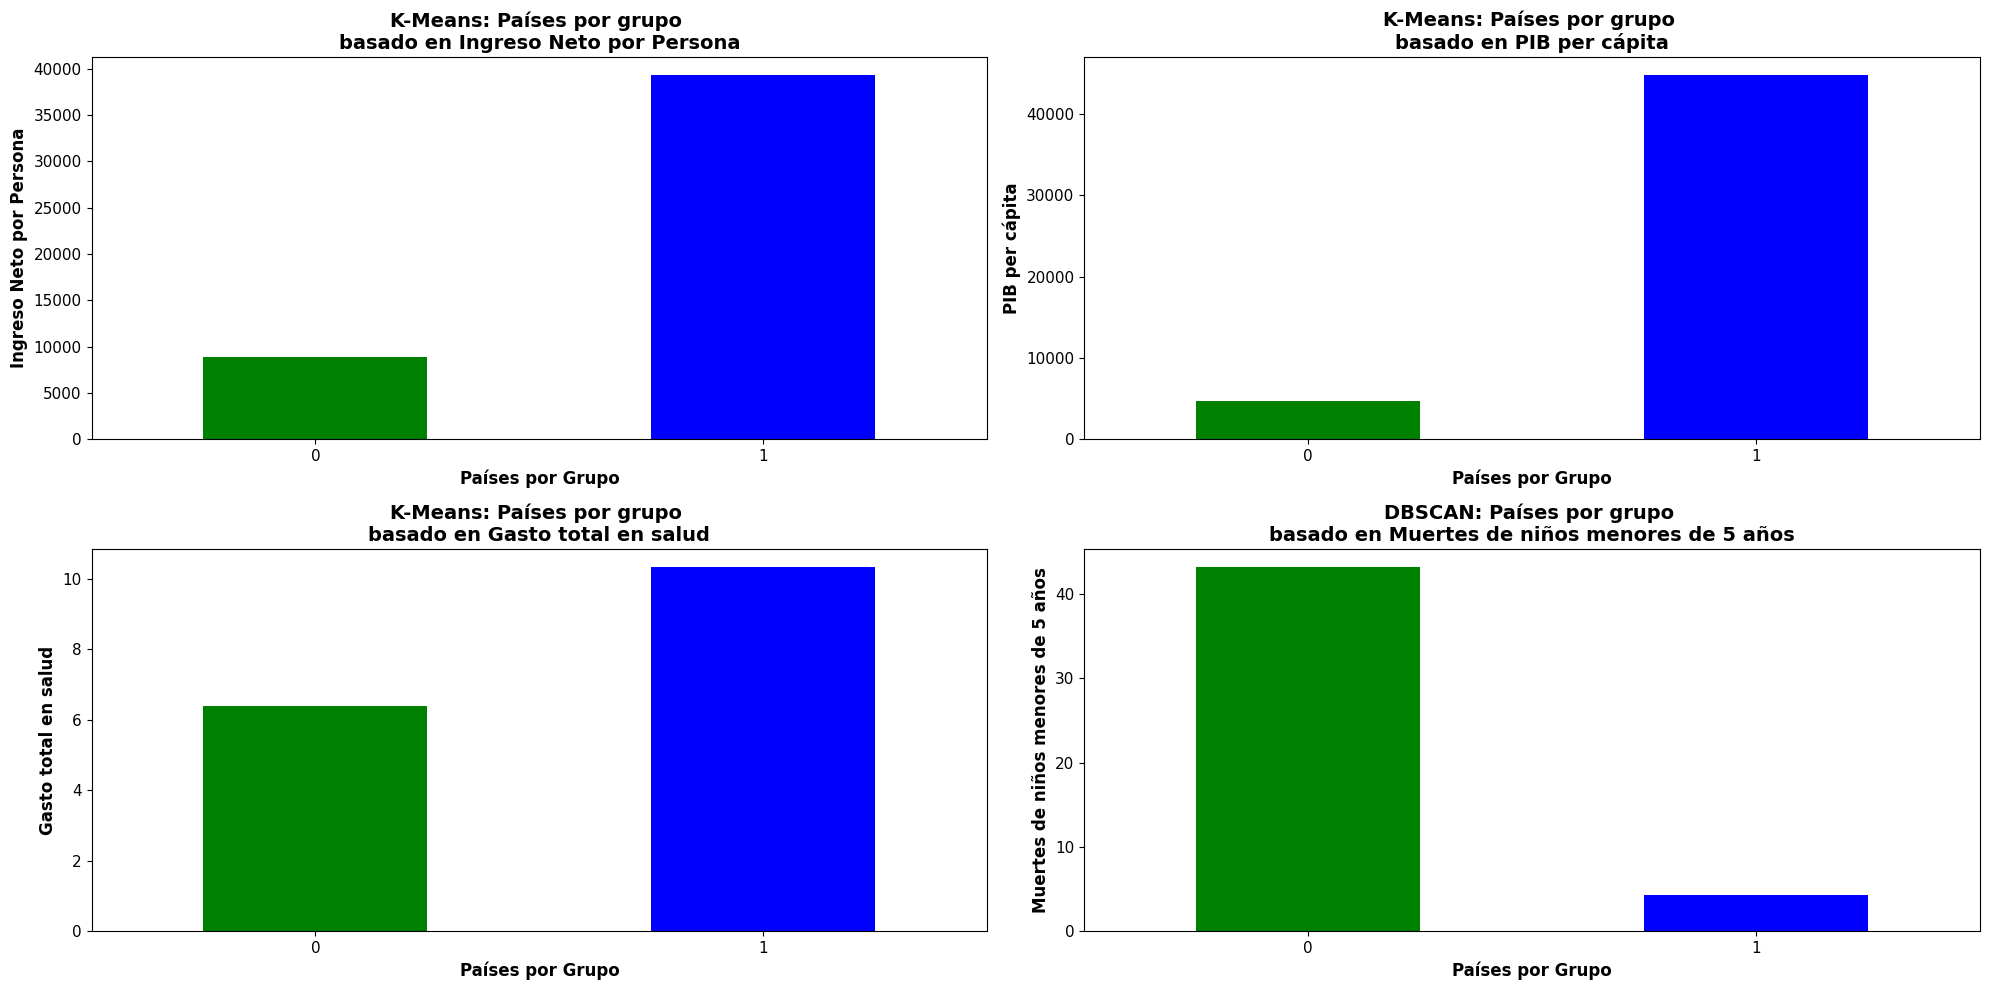

In [ ]:
media_db_f = media_db[media_db['Cluster'] != -1]
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(221)
media_db_f.plot.bar(x='Cluster', y='income', rot=0, legend=False, fontsize=12, color=['g', 'b', 'r'], ax=ax1)
ax1.set_title('K-Means: Países por grupo \nbasado en Ingreso Neto por Persona', fontsize=14, fontweight='bold')
ax1.set_ylabel('Ingreso Neto por Persona', fontsize=12, fontweight='bold')
ax1.set_xlabel('Países por Grupo', fontsize=12, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=11, labelrotation=0)

ax2 = fig.add_subplot(222)
media_db_f.plot.bar(x='Cluster', y='gdpp', rot=0, legend=False, fontsize=12, color=['g', 'b', 'r'], ax=ax2)
ax2.set_title('K-Means: Países por grupo \nbasado en PIB per cápita', fontsize=14, fontweight='bold')
ax2.set_ylabel('PIB per cápita', fontsize=12, fontweight='bold')
ax2.set_xlabel('Países por Grupo', fontsize=12, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=11, labelrotation=0)

ax3 = fig.add_subplot(223)
media_db_f.plot.bar(x='Cluster', y='health', rot=0, legend=False, fontsize=12, color=['g', 'b', 'r'], ax=ax3)
ax3.set_title('K-Means: Países por grupo \nbasado en Gasto total en salud', fontsize=14, fontweight='bold')
ax3.set_ylabel('Gasto total en salud', fontsize=12, fontweight='bold')
ax3.set_xlabel('Países por Grupo', fontsize=12, fontweight='bold')
ax3.tick_params(axis='both', which='major', labelsize=11, labelrotation=0)

ax4 = fig.add_subplot(224)
media_db_f.plot.bar(x='Cluster', y='child_mort', rot=0, legend=False, fontsize=12, color=['g', 'b', 'r'], ax=ax4)
ax4.set_title('DBSCAN: Países por grupo \nbasado en Muertes de niños menores de 5 años', fontsize=14, fontweight='bold')
ax4.set_ylabel('Muertes de niños menores de 5 años', fontsize=12, fontweight='bold')
ax4.set_xlabel('Países por Grupo', fontsize=12, fontweight='bold')
ax4.tick_params(axis='both', which='major', labelsize=11, labelrotation=0)

plt.tight_layout()  # Asegura que no haya solapamientos
plt.show()

In [ ]:
import plotly.express as px

# Crear la columna 'Class' con los nombres de los clusters
paises_nuevo['Class'] = paises_nuevo['Cluster']
paises_nuevo.loc[paises_nuevo['Class'] == -1, 'Class'] = 'Ruido'
paises_nuevo.loc[paises_nuevo['Class'] == 0, 'Class'] = 'Cluster 0'
paises_nuevo.loc[paises_nuevo['Class'] == 1, 'Class'] = 'Cluster 1'

# Crear el mapa coroplético
fig = px.choropleth(
    paises_nuevo,
    locationmode='country names',
    locations='country',  # Asegúrate de que 'country' es el nombre de la columna con los nombres de los países
    title='Clustering DBSCAN',
    color='Class',  # Referencia a la columna 'Class' para la coloración
    color_discrete_map={
        'Ruido': 'Red',
        'Cluster 0': 'Yellow',
        'Cluster 1': 'Green'
    }
)

# Configuraciones de la visualización
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Labels',
    legend_title_side='top',
    title_pad_l=260,
    title_y=0.86
)

# Mostrar la figura
fig.show()

<ipython-input-21-cc61d0f33968>:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Ruido' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



## Clustering: HDBSCAN

**Clustering Jerárquico Basado en Densidad de Aplicaciones con Ruido.**

El algoritmo `HDBSCAN` puede considerarse una extensión de `DBSCAN`. Específicamente, `DBSCAN` asume que el criterio de agrupamiento (es decir, el requisito de densidad) es globalmente homogéneo. En otras palabras, `DBSCAN` puede tener dificultades para identificar con éxito *clusters* con diferentes densidades. `HDBSCAN` alivia esta suposición y explora todas las posibles escalas de densidad al construir una representación alternativa del problema de agrupamiento.

Este enfoque permite que `HDBSCAN` capture clusters de múltiples densidades, lo que lo hace más flexible y robusto en comparación con `DBSCAN`, que se limita a una única escala de densidad.

Antes de aplicar este método a la base de países, veamos cómo funciona.

### **2.1  `cluster.HDBSCAN` como una generalización del algoritmo `cluster.DBSCAN`.**

In [ ]:
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.datasets import make_blobs
#https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.HDBSCAN.html


def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    #La probabilidad de que un punto pertenezca al cluster al que ha sido etiquetado determina el tamaño de su marcador.
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # El color negro es utilizado para encontrar marcar el ruido.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "Real" if ground_truth else "Estimado"
    title = f"{preamble} número de clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

#### **2.1.1 Generación de Datos:**

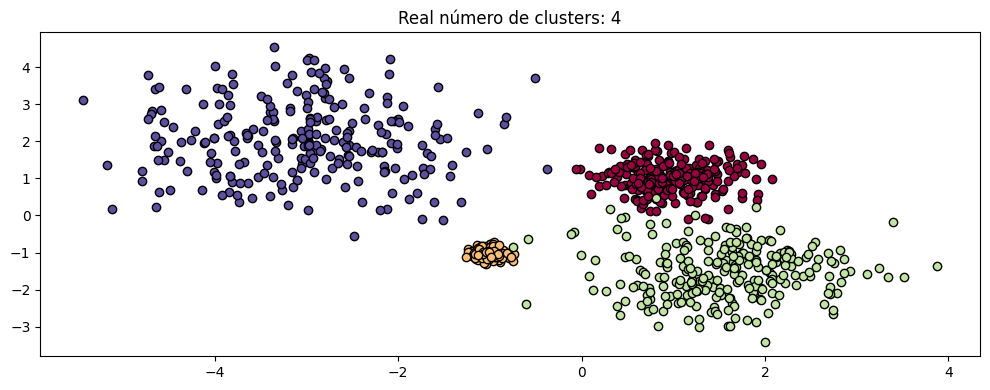

In [ ]:
centers = [[1, 1], [-1, -1], [1.5, -1.5], [-3,2]]
X, labels_true = make_blobs(
    n_samples=1000, centers=centers, cluster_std=[0.4, 0.1, 0.75, 1], random_state=0
)
plot(X, labels=labels_true, ground_truth=True)

### **2.1.2 Invariancia de escala**
Es importante recordar que, aunque `DBSCAN` ofrece un valor predeterminado para el parámetro `eps`, este valor raramente es adecuado y debe ajustarse al conjunto de datos específico en uso.

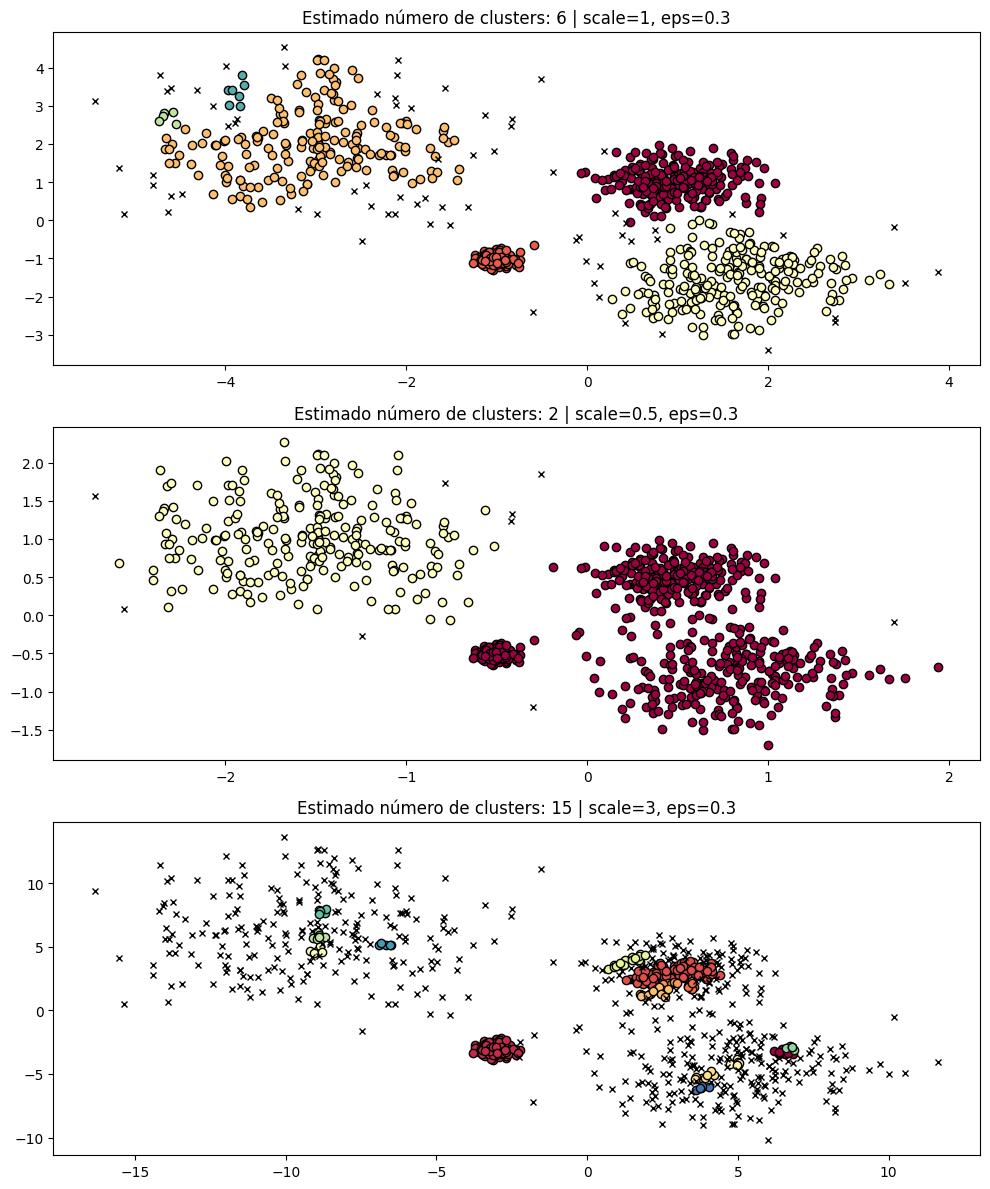

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
dbs = DBSCAN(eps=0.3)
for idx, scale in enumerate([1, 0.5, 3]):
    dbs.fit(X * scale)
    plot(X * scale, dbs.labels_, parameters={"scale": scale, "eps": 0.3}, ax=axes[idx])

Como era de esperar, si escalamos el conjunto de datos (por ejemplo, multiplicando todas las distancias por un factor constante), también será necesario ajustar el parámetro `eps` de manera proporcional para que `DBSCAN` pueda detectar los mismos *clusters*.

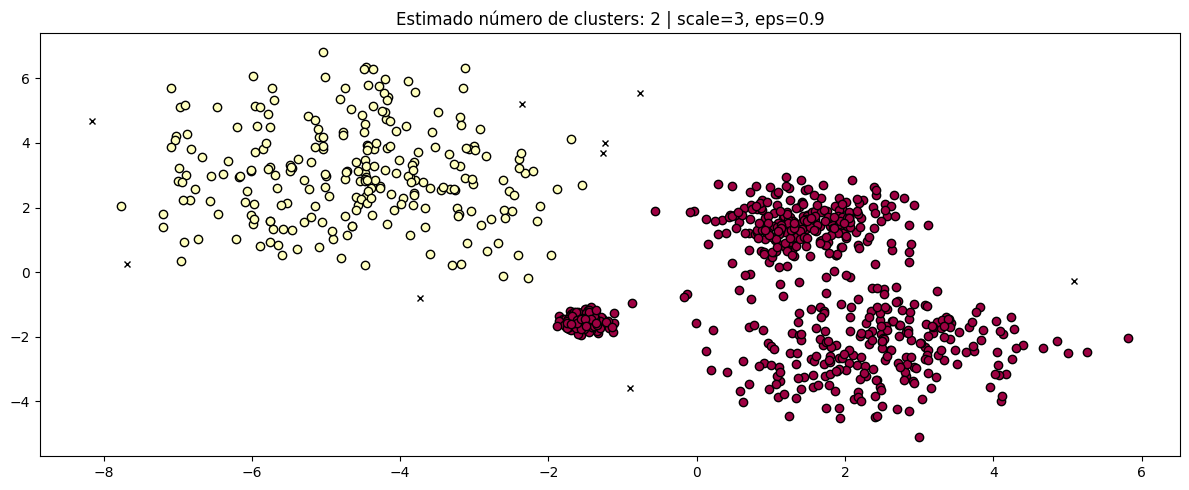

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(12, 5))
dbs = DBSCAN(eps=0.9).fit(1.5 * X)
plot(1.5 * X, dbs.labels_, parameters={"scale": 3, "eps": 0.9}, ax=axis)

Aunque la estandarización de los datos (por ejemplo, usando `sklearn.preprocessing.StandardScaler`) ayuda a reducir este problema, es crucial elegir cuidadosamente el valor de eps en `DBSCAN`.

Por otro lado, `HDBSCAN` es más robusto en este aspecto: se puede considerar que `HDBSCAN` realiza el agrupamiento sobre una variedad de valores de `eps` y luego selecciona los *clusters* más relevantes de entre todos los posibles. Una ventaja importante de este enfoque es que `HDBSCAN` es invariante a la escala.

Esto implica que, a diferencia de `DBSCAN`, no es necesario ajustar manualmente el parámetro `eps` según la escala de los datos. `HDBSCAN` evalúa diferentes valores de `eps` y escoge el que proporciona los *clusters* más estables, lo que le otorga mayor flexibilidad y lo hace menos sensible a cambios en la escala de los datos.

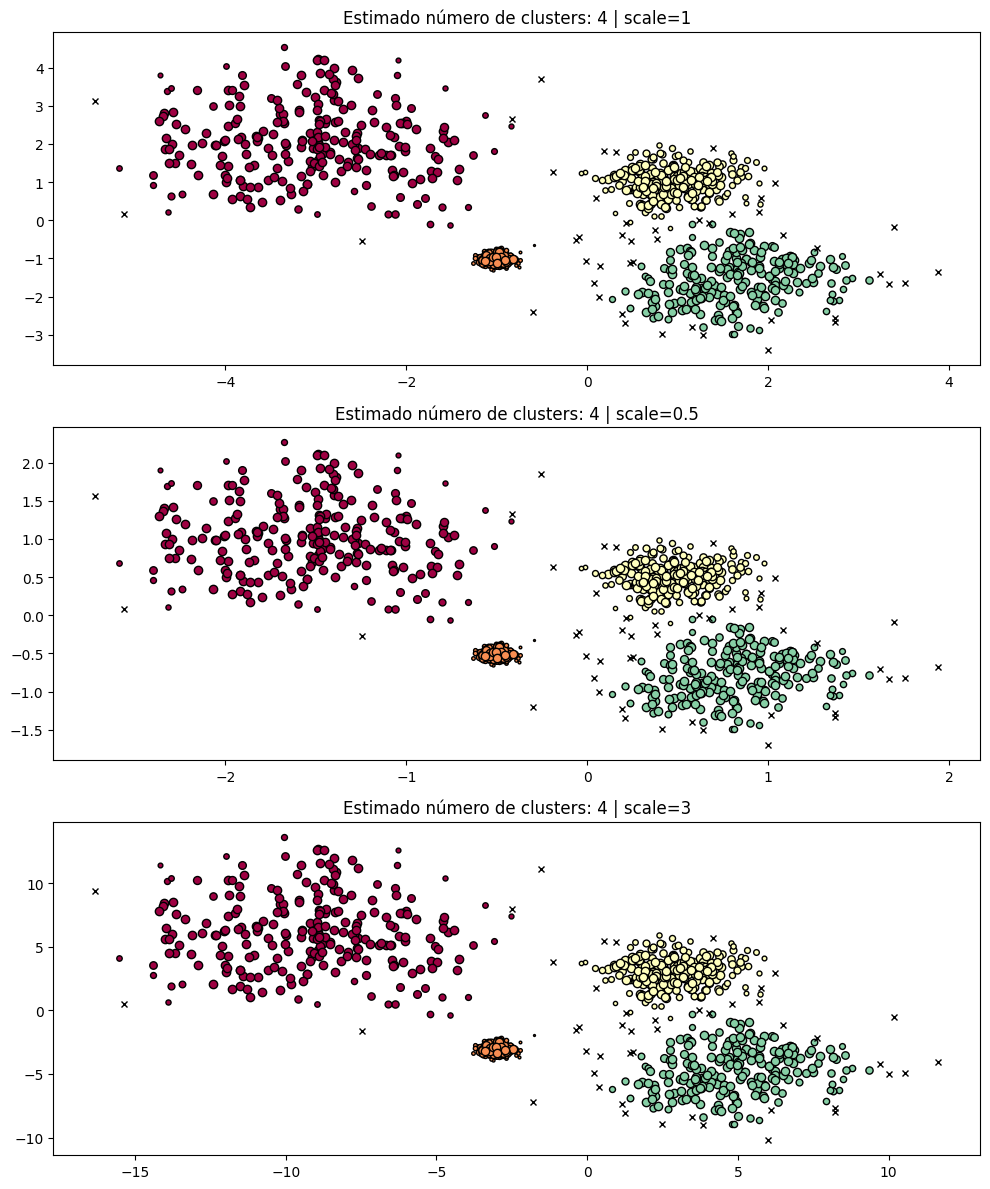

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
hdb = HDBSCAN()
for idx, scale in enumerate([1, 0.5, 3]):
    hdb.fit(X * scale)
    plot(
        X * scale,
        hdb.labels_,
        hdb.probabilities_,
        ax=axes[idx],
        parameters={"scale": scale},
    )

### **2.1.3 Agrupamiento multiescala**

Este enfoque permite que `HDBSCAN` identifique *clusters* que varían en densidad, algo que `DBSCAN` no puede hacer debido a su suposición de que todos los *clusters* tienen la misma densidad. `HDBSCAN` es, por lo tanto, mucho más flexible al tratar con datos que contienen *clusters* de distintas concentraciones o formas.

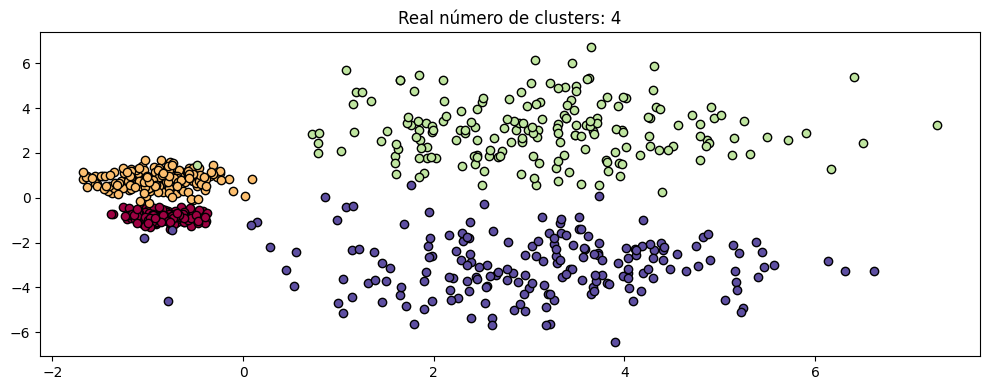

In [ ]:
centers = [[-0.85, -0.85], [-0.85, 0.85], [3, 3], [3, -3]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=[0.2, 0.35, 1.35, 1.35], random_state=0
)
plot(X, labels=labels_true, ground_truth=True)

Este conjunto de datos es más difícil para `DBSCAN` debido a las densidades variables y la separación espacial:

- Si el valor de `eps` es demasiado grande, corremos el riesgo de agrupar incorrectamente los dos *clusters* densos como uno solo, ya que la *alcanzabilidad mutua* de los puntos dentro de los *clusters* se extendería más allá de lo necesario.
  
- Si el valor de `eps` es demasiado pequeño, corremos el riesgo de fragmentar los *clusters* más dispersos en muchos *clusters* falsos.

Además, todo esto requiere ajustar manualmente el valor de `eps` hasta encontrar un equilibrio que nos resulte adecuado.

Esto resalta una de las principales limitaciones de `DBSCAN`, ya que es necesario probar diferentes valores de `eps` y sopesar sus efectos en el agrupamiento, lo que puede ser un proceso largo y sujeto a interpretación. `HDBSCAN`, en cambio, no tiene este problema, ya que no depende de un valor específico de `eps` y puede manejar mejor las variaciones de densidad.

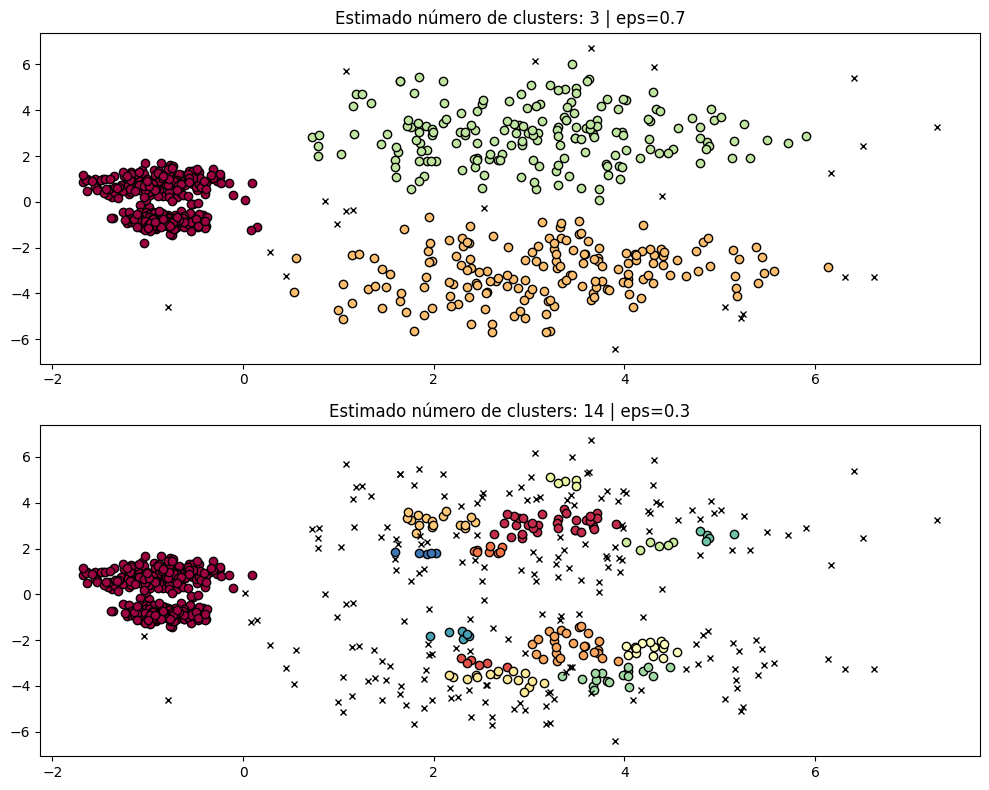

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
params = {"eps": 0.7}
dbs = DBSCAN(**params).fit(X)
plot(X, dbs.labels_, parameters=params, ax=axes[0])
params = {"eps": 0.3}
dbs = DBSCAN(**params).fit(X)
plot(X, dbs.labels_, parameters=params, ax=axes[1])

`HDBSCAN` aborda este problema de manera diferente al realizar agrupamientos multi-escala, lo que le permite identificar *clusters* de diferentes densidades sin necesidad de ajustar un valor único de `eps`. Esto hace que sea más robusto al manejar situaciones donde hay tanto clusters densos como dispersos en el mismo conjunto de datos.

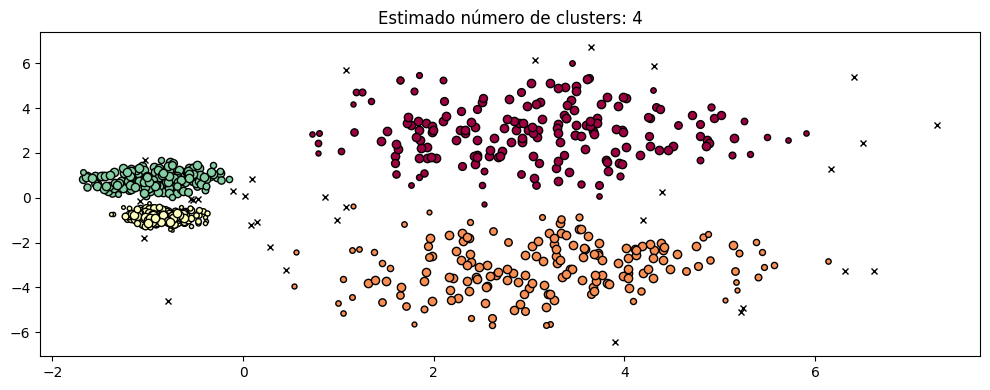

In [ ]:
hdb = HDBSCAN().fit(X)
plot(X, hdb.labels_, hdb.probabilities_)

Esto resalta una de las principales ventajas de `HDBSCAN`: su capacidad para identificar de manera más flexible y precisa *clusters* con diferentes densidades, sin que el usuario tenga que preocuparse por afinar el parámetro `eps`, como sucede en `DBSCAN`.

### **2.1.4 Tratamiento de Hiperparámetros**

Como paso final, el ajuste de hiperparámetros será un paso importante en cualquier aplicación del mundo real.

* **min_cluster_size**: Establece el número mínimo de muestras para considerar un grupo como cluster. Valores pequeños pueden generar sub-clusters falsos, mientras que valores grandes mejoran la robustez frente al ruido.

* **min_samples**: Define el número mínimo de muestras en un vecindario para considerar un punto como central. Un valor mayor mejora la robustez al ruido, pero puede descartar clusters pequeños. Se ajusta después de **min_cluster_size**.


In [ ]:
#########
# TO DO #
#########


### **3.1  Volvamos a la base de Países.**

In [ ]:
hdb = HDBSCAN()
hdb.fit(paises_pca)
clustershdb =hdb.labels_


# Visualizar el resultado
#plt.scatter(paises_pca['PC1'], paises_pca['PC2'], c=clustershdb, cmap='viridis')
#plt.title('HDBSCAN Clustering')
#plt.show()
print(print(pd.Series(clustershdb).value_counts()))

-1    84
 0    66
 1    12
 2     5
Name: count, dtype: int64
None


### **3.2 Analicemos cada uno de los clusters.**


In [ ]:
paises_hdb=pd.merge(paises,pd.Series(clustershdb, index=paises.index, name='Cluster'), left_index=True,right_index=True)

* Media de cada variable agrupada por cluster.

In [ ]:
cluster_child_mort=pd.DataFrame(paises_hdb.groupby(["Cluster"]).child_mort.mean())
cluster_exports=pd.DataFrame(paises_hdb.groupby(["Cluster"]).exports.mean())
cluster_health=pd.DataFrame(paises_hdb.groupby(["Cluster"]).health.mean())
cluster_imports=pd.DataFrame(paises_hdb.groupby(["Cluster"]).imports.mean())
cluster_income=pd.DataFrame(paises_hdb.groupby(["Cluster"]).income.mean())
cluster_inflation=pd.DataFrame(paises_hdb.groupby(["Cluster"]).inflation.mean())
cluster_life_expec=pd.DataFrame(paises_hdb.groupby(["Cluster"]).life_expec.mean())
cluster_total_fer=pd.DataFrame(paises_hdb.groupby(["Cluster"]).total_fer.mean())
cluster_gdpp=pd.DataFrame(paises_hdb.groupby(["Cluster"]).gdpp.mean())

In [ ]:
# Armamos un data frame con las medias de cada variable por cluster.
media_hdb=pd.concat([cluster_child_mort,cluster_exports,cluster_health,cluster_imports,cluster_income,cluster_inflation,cluster_life_expec, cluster_total_fer,cluster_gdpp],axis=1).reset_index()
media_hdb

,Cluster,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,-1,38.094048,46.921429,7.073929,44.928571,26161.797619,9.982298,71.886905,2.918810,21679.630952
1,0,24.965152,38.063318,6.350455,49.738877,9638.787879,5.493909,72.116667,2.423636,5016.500000
2,1,97.783333,26.535000,7.305000,43.808333,1774.333333,6.880417,55.541667,5.288333,767.500000
3,2,74.020000,18.640000,7.444000,49.640000,1624.000000,3.178000,63.620000,4.742000,725.200000


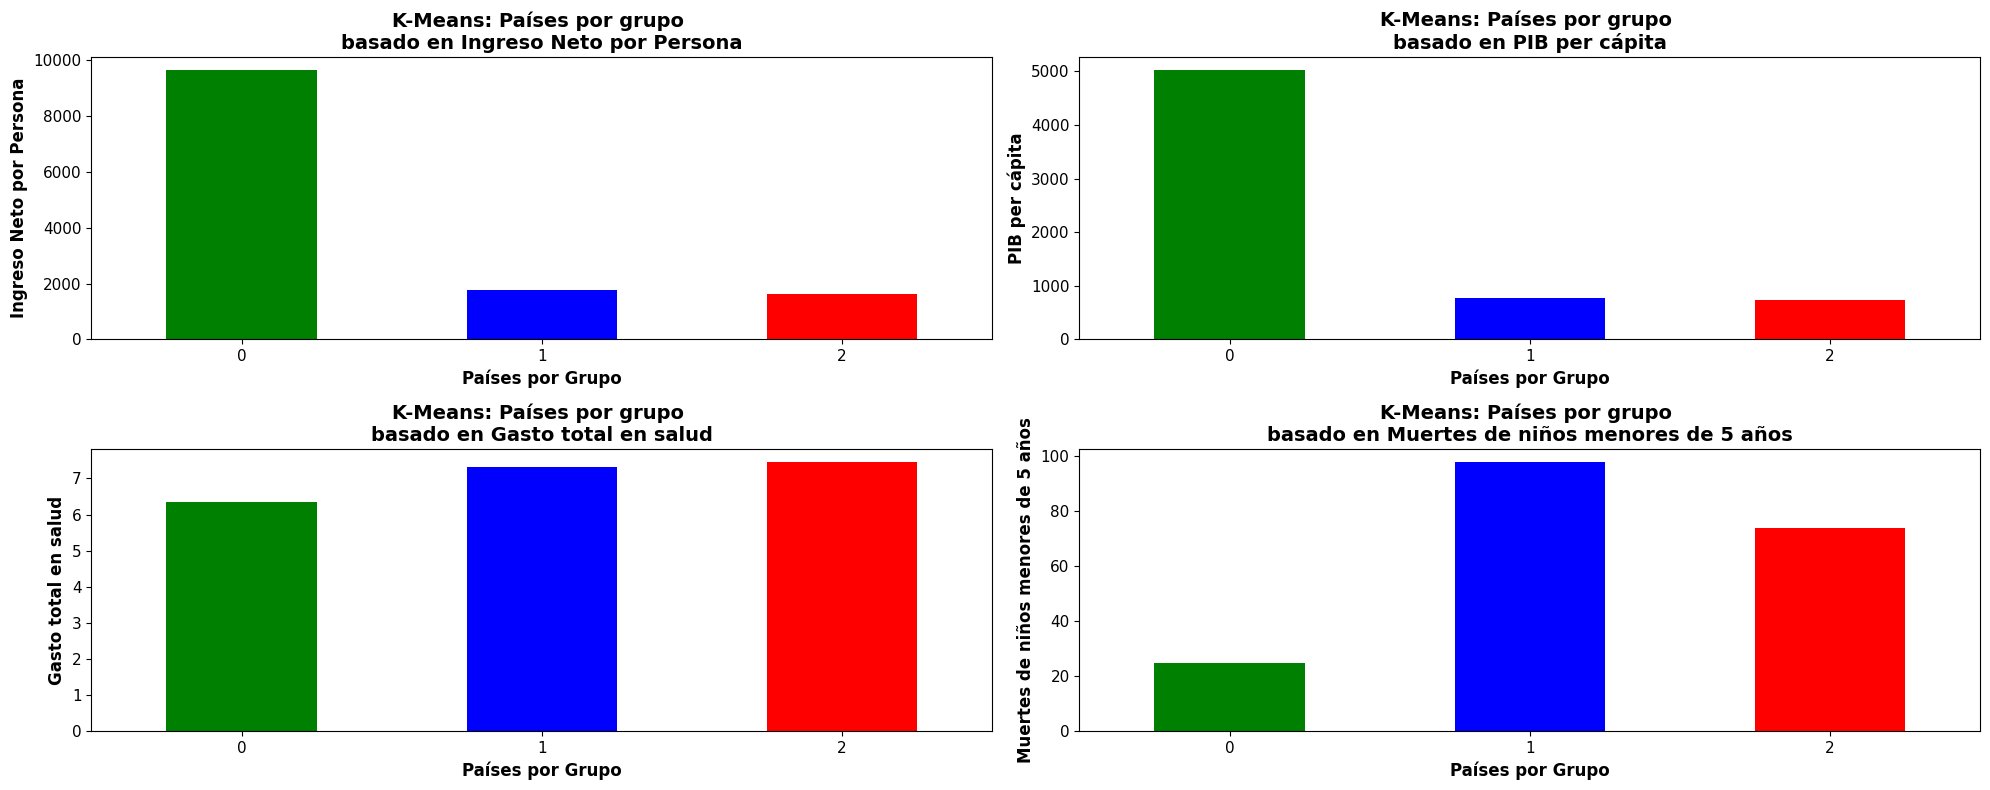

In [ ]:
media_hdb_f= media_hdb[media_hdb['Cluster'] != -1]
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(221)
media_hdb_f.plot.bar(x='Cluster', y='income', rot=0, legend=False, fontsize=12, color=['g', 'b', 'r'], ax=ax1)
ax1.set_title('K-Means: Países por grupo \nbasado en Ingreso Neto por Persona', fontsize=14, fontweight='bold')
ax1.set_ylabel('Ingreso Neto por Persona', fontsize=12, fontweight='bold')
ax1.set_xlabel('Países por Grupo', fontsize=12, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=11, labelrotation=0)

ax2 = fig.add_subplot(222)
media_hdb_f.plot.bar(x='Cluster', y='gdpp', rot=0, legend=False, fontsize=12, color=['g', 'b', 'r'], ax=ax2)
ax2.set_title('K-Means: Países por grupo \nbasado en PIB per cápita', fontsize=14, fontweight='bold')
ax2.set_ylabel('PIB per cápita', fontsize=12, fontweight='bold')
ax2.set_xlabel('Países por Grupo', fontsize=12, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=11, labelrotation=0)

ax3 = fig.add_subplot(223)
media_hdb_f.plot.bar(x='Cluster', y='health', rot=0, legend=False, fontsize=12, color=['g', 'b', 'r'], ax=ax3)
ax3.set_title('K-Means: Países por grupo \nbasado en Gasto total en salud', fontsize=14, fontweight='bold')
ax3.set_ylabel('Gasto total en salud', fontsize=12, fontweight='bold')
ax3.set_xlabel('Países por Grupo', fontsize=12, fontweight='bold')
ax3.tick_params(axis='both', which='major', labelsize=11, labelrotation=0)

ax4 = fig.add_subplot(224)
media_hdb_f.plot.bar(x='Cluster', y='child_mort', rot=0, legend=False, fontsize=12, color=['g', 'b', 'r'], ax=ax4)
ax4.set_title('K-Means: Países por grupo \nbasado en Muertes de niños menores de 5 años', fontsize=14, fontweight='bold')
ax4.set_ylabel('Muertes de niños menores de 5 años', fontsize=12, fontweight='bold')
ax4.set_xlabel('Países por Grupo', fontsize=12, fontweight='bold')
ax4.tick_params(axis='both', which='major', labelsize=11, labelrotation=0)

plt.tight_layout()  # Asegura que no haya solapamientos
plt.show()

In [ ]:

paises_hdb['Class'] = paises_hdb['Cluster']
paises_hdb.loc[paises_hdb['Class'] == -1, 'Class'] = 'Ruido'
paises_hdb.loc[paises_hdb['Class'] == 0, 'Class'] = 'No requiere ayuda'
paises_hdb.loc[paises_hdb['Class'] == 1, 'Class'] = 'Requiere ayuda'
paises_hdb.loc[paises_hdb['Class'] == 2, 'Class'] = 'Podría requerir ayuda'


# Crear el mapa coroplético
fig = px.choropleth(
    paises_hdb,
    locationmode='country names',
    locations='country',  # Asegúrate de que 'country' es el nombre de la columna con los nombres de los países
    title='Clustering HDBSCAN',
    color='Class',  # Referencia a la columna 'Class' para la coloración
    color_discrete_map={'Ruido' : 'Black',
                        'Requiere ayuda':'Red',
                        'Podría requerir ayuda':'Yellow',
                        'No requiere ayuda':'Green'}
)

# Configuraciones de la visualización
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Labels',
    legend_title_side='top',
    title_pad_l=260,
    title_y=0.86
)

# Mostrar la figura
fig.show()

<ipython-input-37-5b6c13aa916f>:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Ruido' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



## **Caso 2: Tarjetas de Crédito (Caso 4 de la Clase 3)**

Se pretende desarrollar una agrupación de clientes para definir una estrategia de marketing. El conjunto de datos resume el comportamiento de uso de aproximadamente 9000 titulares activos de tarjetas de crédito durante los últimos 6 meses. El archivo está a nivel de cliente y contiene 18 variables de comportamiento.

* `CUST_ID`: Identificación del titular de la tarjeta de crédito (Categórica).
*`BALANCE`: Monto del saldo restante en su cuenta para realizar compras.
*`BALANCE_FREQUENCY`: Frecuencia con la que se actualiza el saldo, puntuación entre 0 y 1 (1 = saldo actualizado con frecuencia, 0 = no se actualiza con frecuencia).
* `PURCHASES`: Monto de las compras realizadas desde la cuenta.
* `ONEOFF_PURCHASES`: Monto máximo de compra realizado de una sola vez.
* `INSTALLMENTS_PURCHASES`: Monto de las compras realizadas en cuotas.
* `CASH_ADVANCE`: Efectivo adelantado proporcionado por el usuario.
* `PURCHASES_FREQUENCY`: Frecuencia con la que se realizan las compras, puntuación entre 0 y 1 (1 = compras frecuentes, 0 = no se realizan compras con frecuencia).
* `ONEOFFPURCHASESFREQUENCY`: Frecuencia con la que se realizan compras de una sola vez (1 = compras frecuentes, 0 = no se realizan compras con frecuencia).
* `PURCHASESINSTALLMENTSFREQUENCY`: Frecuencia con la que se realizan compras en cuotas (1 = compras frecuentes, 0 = no se realizan compras con frecuencia).
* `CASHADVANCEFREQUENCY`: Frecuencia con la que se realiza el adelanto de efectivo.
* `CASHADVANCETRX`: Número de transacciones realizadas con "Efectivo Adelantado".
* `PURCHASES_TRX`: Número de transacciones de compra realizadas.
* `CREDIT_LIMIT`: Límite de la tarjeta de crédito para el usuario.
* `PAYMENTS`: Monto del pago realizado por el usuario.
* `MINIMUM_PAYMENTS`: Monto mínimo de pagos realizado por el usuario.
* `PRCFULLPAYMENT`: Porcentaje de pago completo realizado por el usuario.
* `TENURE`: Duración del servicio de tarjeta de crédito para el usuario.